In [1]:
import torch
import numpy as np
from tqdm.auto import tqdm
from transformers import AutoModel, AutoProcessor
from datasets import load_dataset

In [2]:
MODEL = 'openai/clip-vit-large-patch14'
IMAGE = 'TREC-AToMiC/AToMiC-Images-v0.2'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(MODEL)
processor = AutoProcessor.from_pretrained(MODEL)
images = load_dataset(IMAGE, split='train')

Using custom data configuration TREC-AToMiC--AToMiC-Images-v0.2-275960c34975be87
Found cached dataset parquet (/store/scratch/j587yang/.cache/TREC-AToMiC___parquet/TREC-AToMiC--AToMiC-Images-v0.2-275960c34975be87/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [3]:
IMAGE_STYLES = [
    'Photographs: taken with a camera, created by light falling on a photosensitive surface, usually photographic film or an electronic image sensor',
    'Artworks: created by an artist or designer, such as paintings, drawings, and sculptures',
    'Charts: that use shapes and colors to represent data',
    'Diagrams: that use lines, shapes, and labels to explain a concept or process',
    'Relation Graphs: that use nodes and edges to show the relationship between different variables',
    'Typography: use texts, numbers, or symbols as the main element',
    'Icons: a simple graphic symbol that represents an concept, an object, or a function',
    'Geometric designs: that use geometric shapes as the main design element',
    'Maps: that show geographic locations and features'
    'Infographics: that combine text and graphics to present information in a concise and easy-to-understand format',
    'Panoramic images: that show a wide angle view of a scene',
    'Micrographs: taken with a microscope',
    'Astrophotography: taken of astronomical objects',
    'Thermal images: taken using infrared cameras',
    'X-ray or MRI: taken using X-ray or MRI technology',
]

TEMPLATES = [
    'an image of {}',
    'an rendering of {}',
]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] # format with class
            texts = processor(text=texts, padding='max_length', max_length=77, return_tensors='pt') # tokenize
            for key, val in texts.items():
                texts[key] = val.to(DEVICE)
            class_embeddings = model.get_text_features(**texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1)
    return zeroshot_weights

classes = np.array(IMAGE_STYLES)
zeroshot_weights = zeroshot_classifier(classes, TEMPLATES)

  0%|          | 0/14 [00:00<?, ?it/s]

In [4]:
import random

random.seed(9981)
random_index = [random.randint(0, len(images)) for i in range(4)]
random_index

[4480299, 1616657, 252169, 2695940]

In [5]:
inputs = processor(images=images.select(random_index)['image'], return_tensors='pt')
output = model.get_image_features(**inputs)                
output /= output.norm(dim=-1, keepdim=True)
logits = output @ zeroshot_weights
probs = torch.nn.functional.softmax(100 * logits, dim=1)
scores, indicies = probs.topk(k=1, dim=1)

scores = scores.detach().cpu().numpy().squeeze()
indicies = indicies.detach().cpu().numpy().squeeze()
pred_cls = [name.split(':')[0] for name in classes[indicies]]

pred_cls

['Artworks', 'Artworks', 'Photographs', 'Panoramic images']

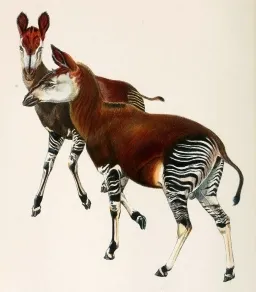

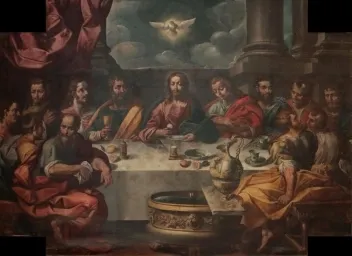

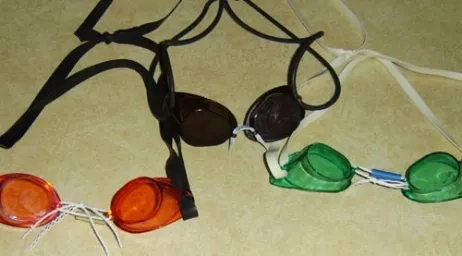

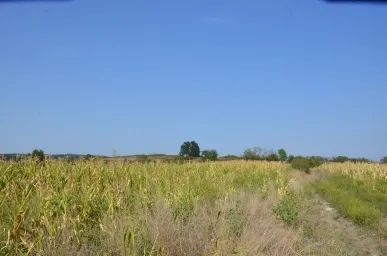

In [6]:
from IPython.display import display

for image in images.select(random_index)['image']:
    display(image)